## Unzip dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! unzip asl/groups.zip -d asl/dataset

In [ ]:
! rm -rf /content/asl/dataset/toddler


## Load Modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import os
from torch import nn
from torch import optim #optimizer
import torch.nn.functional as F #contains layers
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler 
import torchvision
from torch.autograd import Variable
from PIL import Image

## Organise data

In [2]:
rm -rf /content/asl/dataset/.ipynb_checkpoints

In [3]:
data_dir = '/content/asl/dataset'
def load_split_data(data_dir, valid_set_size = .2):
  #apply data agumentation
  train_transforms = transforms.Compose([
                                      transforms.RandomRotation(5),
                                      transforms.Resize((244, 244)),
                                      transforms.RandomVerticalFlip(0.5),
                                      transforms.ToTensor(),
  ])
  test_transforms = transforms.Compose([
                                        transforms.RandomRotation(5),
                                        transforms.RandomVerticalFlip(0.5),
                                        transforms.Resize((244, 244)),
                                        transforms.ToTensor(),
  ])

  train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
  test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

  # class_names = train_data.classes
  # print(class_names)
  num_train = len(train_data)
  indices = list(range(num_train))
  # print(indices)
  split = int(np.floor(valid_set_size * num_train))
  np.random.shuffle(indices)
  train_idx, test_idx = indices[split:] , indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
  testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)

  return trainloader, testloader
trainloader, testloader = load_split_data(data_dir)
classes = trainloader.dataset.classes
classes

['Adults', 'Teenagers', 'Toddler']

## check GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Using transfer Learning

## Load a pretrained model

Here we are using ResNet50

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [5]:
model = models.resnet50(pretrained=True, progress=True)
# print(model)

## Train Model

First, we have to freeze the pre-trained layers, so we don’t backprop through them during training(this is the main logic of transfer learning).

Then, we re-define the final fully-connected the layer(the last layer), the one that we’ll train with our images. We also create the criterion (the loss function) and pick an optimizer (Adam in this case) and learning rate.


> Change the optimizer with something else.



In [6]:
# freezing layers
for param in model.parameters():
  # print(param)
  param.requires_grad = False


In [7]:
# Re-define the last layer i.e.(```(fc): Linear(in_features=2048, out_features=1000, bias=True)```)
model.fc = nn.Sequential(
    nn.Linear(2048,512), #Applies a linear transformation to the incoming datay = xA^T + b
    nn.ReLU(), # apply element wise non linearity
    nn.Dropout(0.2), #randomly zeroes some of the elements of the input tensor
    nn.Linear(512,3),
    nn.LogSoftmax(dim=1) #see what is dim 
)

In [16]:
# definie optimizer , loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr = 0.001)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train Model
You load the batches of images and do the feed forward loop. Then calculate the loss function, and use the optimizer to apply gradient descent in back-propagation.

In validation,set the model to eval() mode, and then back to train() once finished.

In [22]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
    # print(inputs.shape())
    steps+=1
    inputs,labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss = loss.item()

    if steps%print_every==0:
      test_loss =0
      accuracy=0
      model.eval()
      with torch.no_grad():
        for inputs,labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model.forward(inputs)
          batch_loss = criterion(outputs, labels)
          test_loss += batch_loss.item()
          ps = torch.exp(outputs)
          top_p, top_class = ps.topk(1, dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
          if(accuracy//2>0.40):
            break
      train_losses.append(running_loss/(len(trainloader)))
      test_losses.append(test_loss/len(testloader))
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/print_every:.3f}.. "
            f"Test loss: {test_loss/len(testloader):.3f}.. "
            f"Test accuracy: {accuracy/len(testloader):.3f}")
      running_loss = 0
      model.train()

torch.save(model, 'maskmodel.pk') #mask model

Epoch 2/10.. Train loss: 0.038.. Test loss: 0.424.. Test accuracy: 0.411
Epoch 3/10.. Train loss: 0.035.. Test loss: 0.423.. Test accuracy: 0.411
Epoch 5/10.. Train loss: 0.036.. Test loss: 0.465.. Test accuracy: 0.389
Epoch 6/10.. Train loss: 0.039.. Test loss: 0.469.. Test accuracy: 0.400
Epoch 8/10.. Train loss: 0.042.. Test loss: 0.507.. Test accuracy: 0.411
Epoch 9/10.. Train loss: 0.052.. Test loss: 0.445.. Test accuracy: 0.444
Epoch 10/10.. Train loss: 0.035.. Test loss: 0.453.. Test accuracy: 0.444


In [21]:
len(testloader)

2

Plot Losses

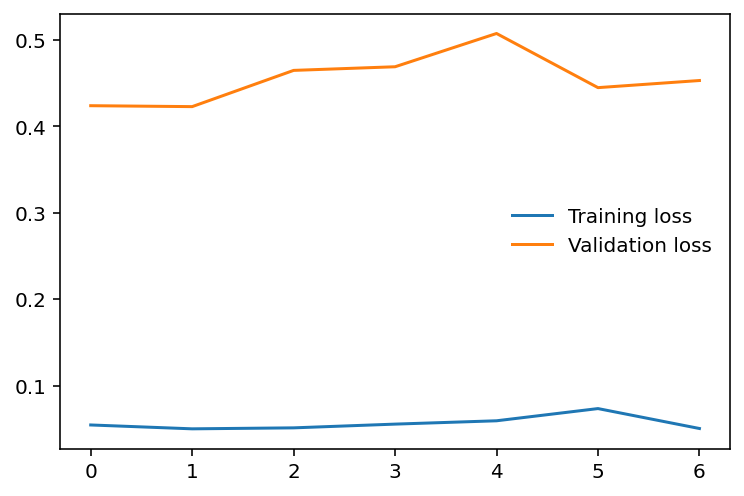

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Check if using gpu and put model in evaluation mode so as to not change parameters

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.load('aerialmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Predict Images
The function that predicts the class of a specific image is very simple. Note that it requires a Pillow image, not a file path.

In [25]:
test_transforms = transforms.Compose([
                                      transforms.Resize((120, 120)),
                                      transforms.ToTensor(),
])

In [26]:
# ! unzip /content/drive/My\ Drive/datasets/TestData.zip -d atest/

Adults


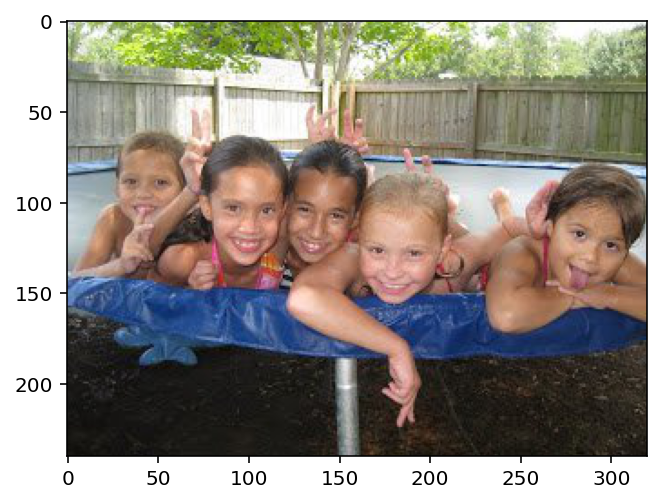

In [27]:
img = Image.open('/content/atest/Test Data/Img6376.jpg')
image_tensor = test_transforms(img).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model(input)
index = output.data.cpu().numpy().argmax()
# print(image_tensor)
print(classes[index])
plt.imshow(img)

test




In [28]:
test_data = pd.read_csv('/content/Test.csv')
test_data

,Filename
0,Img1137.jpg
1,Img3633.jpg
2,Img1474.jpg
3,Img3459.jpg
4,Img5578.jpg
...,...
309,Img2040.jpg
310,Img1951.jpg
311,Img5148.jpg
312,Img3968.jpg


In [29]:
test_data.insert(1,column='Category',value='teen')

In [30]:
test_data

,Filename,Category
0,Img1137.jpg,teen
1,Img3633.jpg,teen
2,Img1474.jpg,teen
3,Img3459.jpg,teen
4,Img5578.jpg,teen
...,...,...
309,Img2040.jpg,teen
310,Img1951.jpg,teen
311,Img5148.jpg,teen
312,Img3968.jpg,teen


In [31]:
def predict_image(path,i):
  img = Image.open(os.path.join("/content/atest/Test Data/",path))
  image_tensor = test_transforms(img).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = model(input)
  index = output.data.cpu().numpy().argmax()
  # print(image_tensor)
  test_data["Category"][i]=str(classes[index])
  # plt.imshow(img)

In [32]:
for i in range(314):
  path = test_data["Filename"][i]
  predict_image(path,i)

In [33]:
test_data

,Filename,Category
0,Img1137.jpg,Teenagers
1,Img3633.jpg,Teenagers
2,Img1474.jpg,Adults
3,Img3459.jpg,Toddler
4,Img5578.jpg,Adults
...,...,...
309,Img2040.jpg,Teenagers
310,Img1951.jpg,Teenagers
311,Img5148.jpg,Adults
312,Img3968.jpg,Teenagers


In [34]:
test_data.to_csv('sample.csv')